Propagating Distributions through Passband Luminosities
================================================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

As always, let's do imports and initialize a logger and a new bundle.

In [2]:
import phoebe
from phoebe.dependencies import distl
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

Since the [pblum_mode](../tutorials/pblum.ipynb) is set to component-coupled, the passband luminosity of the secondary star is determined on-the-fly during computation of the light curve, and so is not available with normal distribution propagation through constraints.  Instead, we'll need to manually propagate the constraint through [b.compute_pblums](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md).

In [3]:
b.add_dataset('lc', times=phoebe.linspace(0,1,101))

<ParameterSet: 80 parameters | contexts: dataset, figure, constraint, compute>

In [4]:
print(b.filter(qualifier='pblum*'))

ParameterSet: 3 parameters
          pblum_mode@lc01@dataset: component-coupled
     pblum_component@lc01@dataset: primary
       pblum@primary@lc01@dataset: 12.566370614359172 W


Here we'll create distribution on the passband luminosity of the primary star and a few other parameters that will affect the passband luminosity coupling to the secondary star.  Note that propagating distributions from the output of sampling runs would follow a similar process.

In [5]:
b.add_distribution({'pblum@primary': phoebe.gaussian_around(0.1),
                    'teff@secondary': phoebe.gaussian_around(100),
                    'requiv@secondary': phoebe.gaussian_around(0.1)},
                   distribution='mydist')

<ParameterSet: 3 parameters | components: secondary, primary>

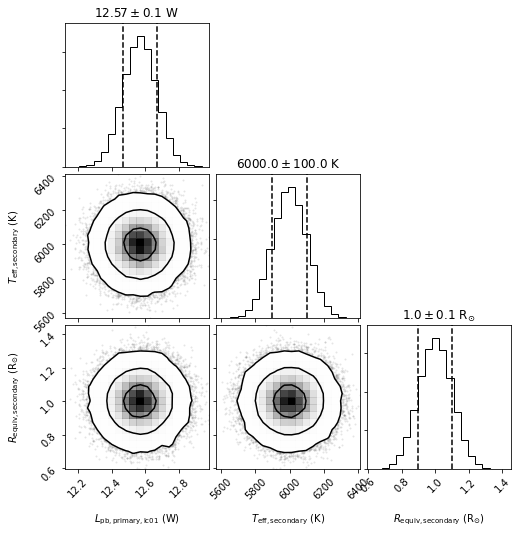

In [6]:
_ = b.plot_distribution_collection('mydist')

By default with two identical stars, calling the primary and secondary star have identical luminosities.

In [7]:
print(b.compute_pblums())

{'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>}


But if we randomly sample from our distributions, the secondary luminosity is also affected.  Unfortunately, this is not handled by a constraint as it requires the mesh to be built and the passband files to be queried in order to handle the coupling logic.

In order to see the distribution of secondary luminosities (or luminosities ratios), we need to repeatedly sample from the distributions and build up a distribution of samples by calling `compute_pblums`.  We could do this manually, or pass it to [distl](https://distl.readthedocs.io) so that we get a distribution object that matches those of any other distribution object in phoebe.

To do this, we'll write a function that takes _individually drawn values_ that affect the desired distribution, set those, calls `compute_pblums`, and returns the matching value.  To avoid modifying the face-values we have in our bundle, we'll make a copy first and act on that copy.

In [8]:
bc = b.copy()

In [9]:
def sample_pblum_secondary(pblum_primary, teff_secondary, requiv_secondary):
    bc.set_value(qualifier='pblum', component='primary', context='dataset', value=pblum_primary)
    bc.set_value(qualifier='teff', component='secondary', context='component', value=teff_secondary)
    bc.set_value(qualifier='requiv', component='secondary', context='component', value=requiv_secondary)
    return bc.compute_pblums().get('pblum@secondary@lc01').value

In [10]:
samples = b.sample_distribution_collection('mydist')
print(samples)

{'pblum@primary@lc01@lc@dataset': 12.544197000775496, 'teff@secondary@star@component': 5993.19974710332, 'requiv@secondary@star@component': 0.9108110635301642}


In [11]:
pblum_secondary = sample_pblum_secondary(samples['pblum@primary@lc01@lc@dataset'],
                                         samples['teff@secondary@star@component'],
                                         samples['requiv@secondary@star@component'])
print(pblum_secondary)

10.340345776493212


If you re-run the two previous cells, you'll see that the randomly drawn values from the distributions will change, and then the return secondary luminosity will be recomputed with those values.

Now we just need to pass this information to create a new distribution by sampling over those input distributions.

In [12]:
dc, _ = b.get_distribution_collection('mydist')
print(dc)

In [13]:
dc.dists

[<distl.gaussian loc=12.566370614359172 scale=0.1 unit=W label=pblum@primary@lc01 label_latex=$L_\mathrm{ pb, primary, lc01 }$>,
 <distl.gaussian loc=6000.0 scale=100.0 unit=K label=teff@secondary label_latex=$T_{ \mathrm{ eff }, \mathrm{ secondary } }$>,
 <distl.gaussian loc=1.0 scale=0.1 unit=solRad label=requiv@secondary label_latex=$R_{ \mathrm{ equiv }, \mathrm{ secondary } }$>]

[distl.function](https://distl.readthedocs.io/en/latest/api/Function.__init__/) takes this callable function as the first argument, a list of the arguments to pass to that function (where instead of passing face values, we'll pass the distributions themselves - distl will then handle sampling each of those an passing individual values for each iteration), and `vectorized=False` since our callable function does not support passing an array of samples.  We'll also assign the distribution object a label and latex-friendly label so that the axes labels match those provided by phoebe.

Note: it is important here that the distributions are passed in the correct order as the function is expecting them.

In [15]:
pblum_sec_dist = distl.function(sample_pblum_secondary,
                                args=(dc.dists[0], dc.dists[1], dc.dists[2]),
                                vectorized=False,
                                label='pblum@secondary@lc01',
                                label_latex='$L_\\mathrm{ pb, secondary, lc01 }$')

In [16]:
pblum_sec_dist.sample(size=5)

array([10.75176148, 14.21009148, 15.24143444, 11.47415707, 16.4344074 ])

To see this distribution in a corner plot with the others to see how they are correlated, we can create a custom distribution collection object which contains all the original distributions as well as our new distribution object.  Now sampling or plotting from this distribution collection object will expose the sampled values from the input distributions as well as the resulting distribution on the secondary luminosity.

In [18]:
dc = distl.DistributionCollection(dc.dists[0], dc.dists[1], dc.dists[2], pblum_sec_dist)

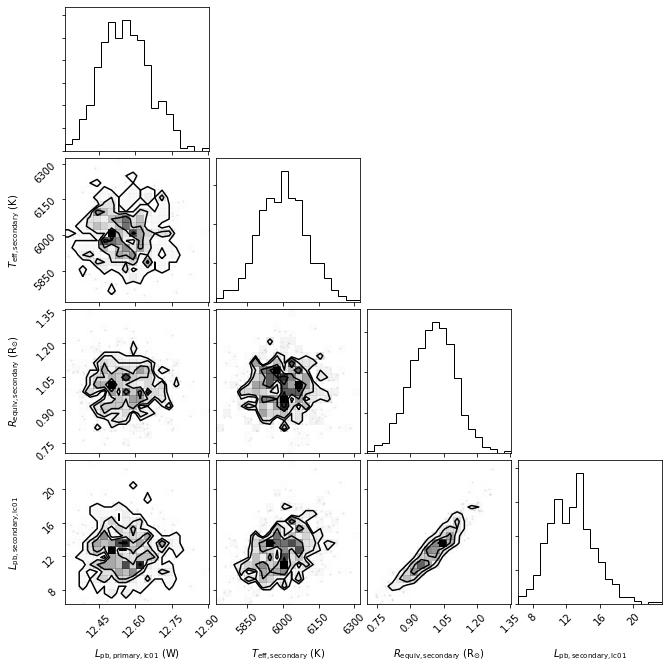

In [19]:
# NOTE: due to a bug in distl, plot_uncertainties=True does not adhere to the passed size
# and so would take a very long time to compute uncertainties by resampling the pblum@secondary
# over 1e5 samples.  Even at 500 samples, this will take some time to compute (several minutes).
_ = dc.plot_sample(size=500, plot_uncertainties=False)